## MachineHack Predict Used Car Sales Price : Author - Rishi 
## Under Top 19 Solution

Driverless cars are getting closer to reality and at a faster pace than ever. But it is still a bit far fetched dream to have one in your garage. For the time being, there are still a lot of combustion and hybrid cars that roar around the road, for some it chills. Though the overall data on sales of automobiles shows a huge drop in sales in the last couple of years, cars are still a big attraction for many. Cars are more than just a utility for many. They are often the pride and status of the family. We all have different tastes when it comes to owning a car or at least when thinking of owning one.

Well here of course as the name suggests we are not concentrating on a new car, rather our interest is in knowing the prices of used cars across the country whether it is a royal l luxury sedan or a cheap budget utility vehicle. In this hackathon, you will be predicting the costs of used cars given the data collected from various sources and distributed across various locations in India.

Size of training set: 6,019 records

Size of test set: 1,234 records

FEATURES:

Name: The brand and model of the car.

Location: The location in which the car is being sold or is available for purchase.

Year: The year or edition of the model.

Kilometers_Driven: The total kilometres driven in the car by the previous owner(s) in KM.

Fuel_Type: The type of fuel used by the car.

Transmission: The type of transmission used by the car.

Owner_Type: Whether the ownership is Firsthand, Second hand or other.

Mileage: The standard mileage offered by the car company in kmpl or km/kg

Engine: The displacement volume of the engine in cc.

Power: The maximum power of the engine in bhp.

Seats: The number of seats in the car.

New_Price: The price of a new car of the same model.

Price: The price of the used car in INR Lakhs

In [108]:
%%time
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, make_scorer, mean_squared_log_error
import lightgbm as lgb
warnings.filterwarnings('ignore')

Wall time: 0 ns


In [109]:
train = pd.read_excel("Data_Train.xlsx")
test = pd.read_excel("Data_Test.xlsx")

### Determining Target column distribution

Text(0.5,1,'Skewness is: 0.754371600099\n, Kurtosis is: 0.310180392914')

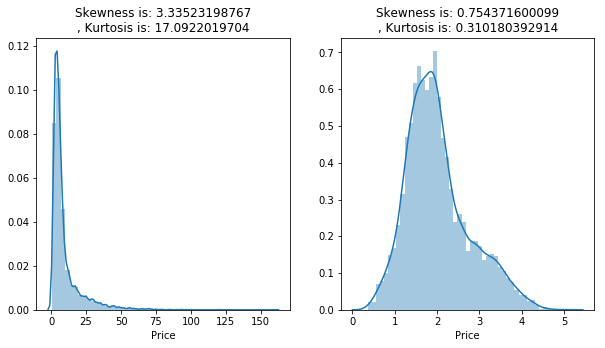

In [110]:
fig, ax= plt.subplots(1,2,figsize=(10,5))
sns.distplot(train.Price, kde=True, ax=ax[0])
train.Price.skew(), train.Price.kurt()
ax[0].set_title('Skewness is: %s\n, Kurtosis is: %s'%((train.Price).skew(), (train.Price).kurt()))
sns.distplot(np.log1p(train.Price), ax=ax[1])
plt.title('Skewness is: %s\n, Kurtosis is: %s'%(np.log1p(train.Price).skew(), np.log1p(train.Price).kurt()))

In [111]:
train.Price = np.log1p(train.Price)
q3 = train.Price.quantile(0.75)
q1 = train.Price.quantile(0.25)
iqr = q3-q1
upper = q3 + 2.5 * iqr
lower = q1 - 2.5 *iqr

d=np.where((train.Price > upper) | (train.Price < lower))
train.drop(index=d[0],inplace=True)
train.reset_index(drop=True, inplace=True)

### Filling missing data

In [112]:
def filler(data,name, engine, power, seat):
    location = data[data.Name == name].index
    for i in location:
        data.ix[location,'Engine'] = engine
        data.ix[location,'Power'] = power
        data.ix[location,'Seats'] = seat
        #print(data.loc[location])
        return(data)

In [113]:
train = filler(train, 'Maruti Swift 1.3 VXi', '1197cc', '82bhp',5) 
train = filler(train, 'Honda City 1.5 GXI' , '1497cc', '117bhp',5)
train = filler(train, 'Maruti Swift 1.3 ZXI', '1248cc', '74bhp',5) 
train = filler(train, 'Honda City 1.3 DX', '1497cc', '117bhp',5) 
train = filler(train, 'Maruti Swift 1.3 LXI', '1248cc', '74bhp',5) 
train = filler(train, 'Maruti Swift 1.3 VXI ABS', '1248cc', '74bhp',5) 
train = filler(train, 'Hyundai Santro LP zipPlus', '1086cc', '58bhp',5) 
train = filler(train, 'Toyota Etios Liva V', '1197cc', '79bhp',5)
 
train = filler(train, 'Land Rover Range Rover Sport 2005 2012 Sport', '4999cc', '503bhp',5)    
train = filler(train, 'BMW 5 Series 520d Sedan', '2993cc', '265bhp',5)
train = filler(train, 'Hyundai Santro GLS II - Euro II', '814cc', '55bhp',5)
train = filler(train, 'Maruti Wagon R Vx', '1197cc', '81.8bhp',5)

train = filler(train, 'Honda CR-V AT With Sun Roof', '1997cc', '154bhp' ,7)
train = filler(train, 'Fiat Punto 1.3 Emotion', '1248cc', '90bhp',5)
train = filler(train, 'Land Rover Range Rover 3.0 D', '2993cc', '255bhp', 7)

train = filler(train, 'Hyundai Santro Xing XG', '1086cc', '63bhp',5)
train = filler(train, 'Hyundai Santro GLS II - Euro II', '1997cc', '154bhp',5)
train = filler(train, 'Honda Jazz Select Edition', '1199cc', '88bhp',5)

train = filler(train, 'Fiat Punto 1.2 Dynamic', '1172cc', '67bhp',5)
train = filler(train, 'Fiat Punto 1.4 Emotion', '1368cc', '88bhp',5)

test = filler(test, 'Maruti Swift 1.3 VXi', '1197cc', '82bhp',5) 
test = filler(test, 'Toyota Etios Liva V', '1197cc', '79bhp',5)
test = filler(test, 'BMW 5 Series 520d Sedan', '2993cc', '265bhp',5)
test = filler(test, 'Fiat Punto 1.4 Emotion', '1368cc', '88bhp',5)
test = filler(test, 'Skoda Laura 1.8 TSI Ambition', '1798cc', '157bhp',5) 
test = filler(test, 'Toyota Etios Liva Diesel TRD Sportivo', '1364cc', '67bhp',5)
test = filler(test, 'Hyundai i20 new Sportz AT 1.4', '1366cc', '89bhp',5)
test = filler(test, 'Mahindra TUV 300 P4', '2179cc', '120bhp',10)


### Minor fixes in Car Names

In [114]:
import re
train.Name = train.Name.apply(lambda x: x.lower())
test.Name = test.Name.apply(lambda x: x.lower())
train.Name = train.Name.apply(lambda x: re.sub('new','',x))
test.Name = test.Name.apply(lambda x: re.sub('new','',x))
train.Name = train.Name.apply(lambda x: re.sub('evo','',x))
test.Name = test.Name.apply(lambda x: re.sub('evo','',x))
train.Name = train.Name.apply(lambda x: re.sub('amt','',x))
test.Name = test.Name.apply(lambda x: re.sub('amt','',x))
train.Name = train.Name.apply(lambda x: re.sub('\s*grande','',x))
train.Name = train.Name.apply(lambda x: re.sub('\s*punto','',x))
test.Name = test.Name.apply(lambda x: re.sub('\s*grande','',x))
test.Name = test.Name.apply(lambda x: re.sub('\s*punto','',x))
train.Name = train.Name.apply(lambda x: re.sub('\s*ikon','',x))
test.Name = test.Name.apply(lambda x: re.sub('\s*ikon','',x))
train.Name = train.Name.apply(lambda x: re.sub('\s*getz','',x))
test.Name = test.Name.apply(lambda x: re.sub('\s*getz','',x))
train.Name = train.Name.apply(lambda x: re.sub('-benz',' ',x))
test.Name = test.Name.apply(lambda x: re.sub('-benz',' ',x))

### Using Regex to get car brand name

In [115]:
import re
pattern = re.compile(r'(Maruti|volvo|jeep|bentley|Hindustan Motors|OpelCorsa|isuzu|chevrolet|fiat|cooper|Hyundai|BMW|Honda|Toyota|datsun|jaguar|Skoda|Audi|Mercedes|Porsche|Mahindra|Nissan|ford|Volkswagen|Tata|land rover|mitsubishi|renault)', re.IGNORECASE)
train['Name_t'] = train.Name.str.extract(pattern)

junk = train[train.Name_t.isnull()]
junk.index
train.drop(index= junk.index, inplace=True)
train.reset_index(drop=True, inplace=True)
test['Name_t'] = test.Name.str.extract(pattern)

### Using Regex to get Brand Model name

In [116]:
pattern = re.compile(r"^(\w*[.]*\w*\s*-*\w*[.]*\w*)")
train['Model'] = train.Name.str.extract(pattern)
test['Model'] = test.Name.str.extract(pattern)

In [117]:
test.Model.replace({'bentley flying': 'bentley continental'}, inplace=True)
train.Model.replace({'fiat  1.2': 'fiat 1.2'}, inplace=True)
test.Model.replace({'fiat  1.3': 'fiat 1.3'}, inplace=True)
train.Model.replace({'fiat  1.3': 'fiat 1.3'}, inplace=True)
test.ix[887,'Power'] = '88bhp'
test.Model.replace({'fiat abarth': 'fiat 1.4'}, inplace=True)

train.Model.replace({'fiat petra':'fiat 1.2'}, inplace=True)
train.Model.replace({'fiat siena':'fiat 1.2'}, inplace=True)
train.Model.replace({'ford fusion':'ford 1.4'}, inplace=True)
train.Model.replace({'ford classic':'ford 1.4'}, inplace=True)
test.Model.replace({'ford classic':'ford 1.4'}, inplace=True)

test.Model.replace({'hindustan motors': 'nissan x'}, inplace=True)
test.Name_t.replace({'hindustan motors': 'nissan'}, inplace=True)
train.Model.replace({'ford classic':'ford 1.4'}, inplace=True)
test.Model.replace({'ford classic':'ford 1.4'}, inplace=True)
train.Model.replace({'honda br':'honda brv'}, inplace=True)
test.Model.replace({'honda br':'honda brv'}, inplace=True)

train.Model.replace({'honda wr':'honda wrv'}, inplace=True)
test.Model.replace({'honda wr':'honda wrv'}, inplace=True)

train.Model.replace({'hyundai gls':'hyundai gle'}, inplace=True)
test.Model.replace({'hyundai gls':'hyundai gle'}, inplace=True)
train.Model.replace({'hyundai gvs':'hyundai gle'}, inplace=True)
train.Model.replace({'hyundai 1.3':'hyundai gle'}, inplace=True)
test.Model.replace({'hyundai gvs':'hyundai gle'}, inplace=True)
test.Model.replace({'hyundai 1.3':'hyundai gle'}, inplace=True)
test.Model.replace({'isuzu mu':'isuzu mux'}, inplace=True)
train.Model.replace({'mahindra e':'mahindra verito'}, inplace=True)

test.Model.replace({'mercedes  c':'mercedes c'}, inplace=True)
train.Model.replace({'mercedes  c':'mercedes c'}, inplace=True)

test.Model.replace({'mercedes   c':'mercedes c'}, inplace=True)
train.Model.replace({'mercedes   c':'mercedes c'}, inplace=True)
test.Model.replace({'mercedes  cla':'mercedes  gla'}, inplace=True)
train.Model.replace({'mercedes  cla':'mercedes  gla'}, inplace=True)
test.Model.replace({'mercedes  gl':'mercedes  gle'}, inplace=True)
train.Model.replace({'mercedes  gl':'mercedes  gle'}, inplace=True)
test.Model.replace({'nissan 370z': 'audi q7'}, inplace=True)
test.Model.replace({'opelcorsa 1.4gsi': 'skoda fabia'}, inplace=True)
test.Name_t.replace({'opelcorsa': 'skoda'}, inplace=True)

test.Model.replace({'tata  safari':'tata safari'}, inplace=True)
train.Model.replace({'tata  safari':'tata safari'}, inplace=True)
test.Model.replace({'toyota land':'toyota fortuner'}, inplace=True)

### Deleting Models which are not present under test files

In [118]:
tr_list = set(list(train.Model.values))
te_list = set(list(test.Model.values))
len(tr_list), len(te_list)

diff=list(tr_list.difference(te_list))
junk = train[train.Model.apply(lambda x : x in diff)]
train.drop(index = junk.index, inplace = True)
train.reset_index(drop=True, inplace=True)

### Removing Outliers and junk values

In [119]:
junk = train[train.Price >5]
train.drop(index = junk.index, inplace = True)
train.reset_index(drop=True, inplace=True)

junk = train[train.Fuel_Type == 'Electric']
train.drop(index= junk.index, inplace=True)
train.reset_index(drop=True, inplace=True)

train.Seats.replace({0.0:5.0}, inplace=True)
train.Seats.replace({9:10}, inplace=True)
train[train.Seats.isnull()]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Name_t,Model
224,ford figo diesel,Bangalore,2015,70436,Diesel,Manual,First,0.0 kmpl,1498 CC,99 bhp,NaN,NaN,1.526056,ford,ford figo
1875,honda city 1.5 exi,Jaipur,2005,88000,Petrol,Manual,Second,13.0 kmpl,1493 CC,100 bhp,NaN,NaN,0.993252,honda,honda city
3712,ford endeavour hurricane le,Mumbai,2012,129000,Diesel,Automatic,First,12.8 kmpl,2953 CC,null bhp,NaN,NaN,2.079442,ford,ford endeavour


In [120]:
train.iloc[224,10] = 5
train.iloc[1875,10] = 5
train.iloc[3712,10] = 7

test.ix[938,'Seats'] = 5

### Extracting info from Mileage, Engine, Power

In [121]:
train['Mileage_t'] = train.Mileage.str.extract(r'(\d*[.]*\d*)')
train['Engine_t'] = train.Engine.str.extract(r'(^\d*)')
train['Power_t']=train.Power.str.extract(r'(^\d*[.]*\d*)')
test['Mileage_t'] = test.Mileage.str.extract(r'(\d*[.]*\d*)')
test['Engine_t'] = test.Engine.str.extract(r'(^\d*)')
test['Power_t'] = test.Power.str.extract(r'(\d*[.]*\d*)')

### Filling missing value of Power with respect to Name, Model, Fuel

In [122]:
train.Power_t.replace('','NaN', inplace=True)
train.Power_t = train.Power_t.astype('float')
test.Power_t.replace('','NaN', inplace=True)
test.Power_t = test.Power_t.astype('float')

df = pd.concat([train,test], axis=0)
df.Power_t=df.groupby(['Name_t', 'Model','Fuel_Type']).Power_t.transform(lambda x: x.fillna(x.median()))
df.reset_index(drop=True , inplace=True)
df.shape, train.shape,test.shape

((7112, 18), (5878, 18), (1234, 17))

In [123]:
7112-1234

5878

In [124]:
train['Power_t'] = df.loc[:5878,'Power_t']
z = df.loc[5878:,'Power_t']
z.reset_index(drop=True, inplace=True)
test['Power_t'] = z

### Converting into proper type using typecasting

In [126]:
train.Engine_t = train.Engine_t.astype('float')
train.Mileage_t = train.Mileage_t.astype('float')
train.Power_t = train.Power_t.astype('float')

test.Engine_t = test.Engine_t.astype('float')
test.Mileage_t = test.Mileage_t.astype('float')
test.Power_t = test.Power_t.astype('float')

### Handling New_Price missing values + 'CR' entries 

In [127]:
df=pd.concat([train,test],axis =0)
df.New_Price.fillna(0, inplace=True)
x=df[df.New_Price.str.contains(r'Cr').fillna(False)].New_Price.str.extract(r'(\d*[.]*\d*)')[0]
x = x.astype('float')*100
index = x.index
x=list(x)
i = 0
for j in list(index):
    df.loc[j,'New_Price'] = x[i]
    i = i + 1
    
df['New_Price_t'] = df.New_Price.str.extract(r'(\d*[.]*\d*)\s*[a-zA-Z]*')
df.New_Price_t = df.groupby(['Model','Fuel_Type']).New_Price_t.transform(lambda x: x.fillna(x.median()))
df.New_Price_t.fillna(df.New_Price_t.median(), inplace=True)
df.New_Price_t = df.New_Price_t.astype('float')
df.New_Price_t = np.log1p(df.New_Price_t)
new=pd.DataFrame(df.groupby(['Name_t'])['New_Price_t'].mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7112 entries, 0 to 1233
Data columns (total 19 columns):
Engine               7112 non-null object
Engine_t             7112 non-null float64
Fuel_Type            7112 non-null object
Kilometers_Driven    7112 non-null int64
Location             7112 non-null object
Mileage              7112 non-null object
Mileage_t            7112 non-null float64
Model                7112 non-null object
Name                 7112 non-null object
Name_t               7112 non-null object
New_Price            7112 non-null object
Owner_Type           7112 non-null object
Power                7112 non-null object
Power_t              7112 non-null float64
Price                5878 non-null float64
Seats                7112 non-null float64
Transmission         7112 non-null object
Year                 7112 non-null int64
New_Price_t          7112 non-null float64
dtypes: float64(6), int64(2), object(11)
memory usage: 1.2+ MB


In [128]:
7112-1234

5878

In [129]:
train = df.iloc[:5878,:]
test = df.iloc[5878:,:]
del test['Price']

## Feature Engineering :
### 1. Creating New column to check how old is your car in years

In [130]:
train['Year_t'] = train.Year.apply(lambda x: 2020 - x )
test['Year_t'] = test.Year.apply(lambda x: 2020 - x )

### 2. Converting owner from categorical to ordinal column + Featuring interaction column 

In [131]:
train.Owner_Type.replace({'First':'1', 'Second':'2', 'Third': '3', 'Fourth & Above': '4'}, inplace=True)
test.Owner_Type.replace({'First':'1', 'Second':'2', 'Third': '3', 'Fourth & Above': '4'}, inplace =True)
train.Owner_Type = train.Owner_Type.astype('int')
test.Owner_Type = test.Owner_Type.astype('int')

train['ow_year'] = np.ceil(train.Owner_Type* train.Year_t/3)
test['ow_year'] = np.ceil(test.Owner_Type* test.Year_t/3)

### 3. Adding one more feature to detemine if its a sports cars

In [132]:
sport = pd.DataFrame(train.groupby('Name_t').Price.median()>2.5)
y = list(sport[sport.Price==True].index)

train['Sport'] = train.Name_t.apply(lambda x: 1 if x in y else 0)
test['Sport'] = test.Name_t.apply(lambda x: 1 if x in y else 0)

train['Sport_1'] = train.Engine_t.apply(lambda x: 0 if x<2000 else 1)
test['Sport_1'] = test.Engine_t.apply(lambda x: 0 if x<2000 else 1)
train['Sport_2'] = train.Power_t.apply(lambda x: 0 if x<140 else 1)
test['Sport_2'] = test.Power_t.apply(lambda x: 0 if x<140 else 1)
train['Sport'] = train.Sport+train.Sport_1+train.Sport_2
test['Sport'] = test.Sport+test.Sport_1+test.Sport_2
train.Sport = np.where(train.Sport == 3 , 1 , 0)
test.Sport = np.where(test.Sport == 3 , 1 , 0)
train.drop(columns=['Sport_1', 'Sport_2'], inplace=True)
test.drop(columns=['Sport_1', 'Sport_2'], inplace=True)

### 4. Adding one more column if car has mileage 0 means may be car is not working

In [133]:
train['Mileage_zero'] = np.where(train.Mileage_t==0,1,0)
test['Mileage_zero'] = np.where(test.Mileage_t==0,1,0)

### Dropping Unwanted columns and proper type conversion

In [134]:
train.drop(columns=['Name','Mileage','Year','Engine','Power'], inplace=True)
test.drop(columns=['Name','Mileage','Year','Engine','Power'], inplace=True)

del train['New_Price']
del test['New_Price']
for i in train.columns:
    if train[i].dtype == 'O' :
        train[i] = train[i].astype('category')

for i in test.columns:
    if test[i].dtype == 'O' :
        test[i] = test[i].astype('category')

### Converting kilometers into Normal distribution curve

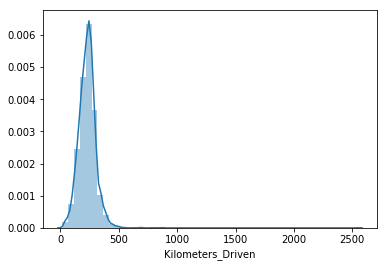

In [135]:
sns.distplot(np.sqrt(train.Kilometers_Driven))
np.sqrt(train.Kilometers_Driven).skew(), np.sqrt(train.Kilometers_Driven).kurt()
train['Kilometers_Driven'] = np.sqrt(train.Kilometers_Driven)
test['Kilometers_Driven'] = np.sqrt(test.Kilometers_Driven)

In [136]:
# filling Power value as mean
train.Power_t.fillna(111, inplace=True)
test.Power_t.fillna(110.0, inplace=True)

### Convert Model into Encoding

In [137]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df = pd.concat([train, test],axis=0)
df.Model = le.fit_transform(df.Model)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7112 entries, 0 to 1233
Data columns (total 17 columns):
Engine_t             7112 non-null float64
Fuel_Type            7112 non-null category
Kilometers_Driven    7112 non-null float64
Location             7112 non-null category
Mileage_t            7112 non-null float64
Mileage_zero         7112 non-null int32
Model                7112 non-null int32
Name_t               7112 non-null category
New_Price_t          7112 non-null float64
Owner_Type           7112 non-null int32
Power_t              7112 non-null float64
Price                5878 non-null float64
Seats                7112 non-null float64
Sport                7112 non-null int32
Transmission         7112 non-null category
Year_t               7112 non-null int64
ow_year              7112 non-null float64
dtypes: category(4), float64(8), int32(4), int64(1)
memory usage: 696.7 KB


In [138]:
7112-1234

5878

In [139]:
train.Model = df.iloc[:5878,6]
test.Model = df.iloc[5878:,6]

# Seats into Ordinal variable
train.Seats = train.Seats.astype('int')
test.Seats = test.Seats.astype('int')

train.Seats.replace({2:1, 4:2, 5:3, 6:4, 7:5 ,8:6, 10:7}, inplace=True)
test.Seats.replace({2:1, 4:2, 5:3, 6:4, 7:5 ,8:6, 10:7}, inplace=True)

# Deleting Mileage
del train['Mileage_t']
del test['Mileage_t']

# Converted into Normal distibution
train.Power_t = np.log1p(train.Power_t)
train.Engine_t = np.log1p(train.Engine_t)
test.Power_t = np.log1p(test.Power_t)
test.Engine_t = np.log1p(test.Engine_t)

# Scaling down 
train.Kilometers_Driven = train.Kilometers_Driven/1000
test.Kilometers_Driven = test.Kilometers_Driven/1000

train = pd.get_dummies(train,drop_first=True)
test = pd.get_dummies(test,drop_first=True)

In [140]:
train_label = train.Price
del train['Price']

In [141]:
train.shape, test.shape

((5878, 50), (1234, 50))

## Modeling time

In [142]:
from sklearn.metrics import mean_squared_error

In [143]:
def CrossVal(dataX,dataY,mode,cv=5):
    score=cross_val_score(mode,dataX , dataY, cv=cv, scoring=metric)
    print("cv score",np.mean(score))
    return(np.mean(score))

In [144]:
def rmsle(y_pred, y_test) : 
    return(1-(np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_test))**2))))
metric = make_scorer(rmsle)

In [145]:
CrossVal(train, train_label,model)

cv score 0.953029137428


0.95302913742832973

In [146]:
model = lgb.LGBMRegressor(bagging_fration=0.76999999999999991, boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.28999999999999998, importance_type='split',
       lambda_l1=0.36999999999999994, lambda_l2=0.050000000000000003,
       learning_rate=0.03, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_gain_split=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=86, objective=None,
       random_state=975, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
model.fit(train, train_label)
answer = model.predict(test)

In [147]:
ans = pd.DataFrame({'Price':np.exp(answer)-1})
ans.to_excel('answer.xlsx', index = False)
ans.tail()

,Price
1229,4.250536
1230,5.887569
1231,2.947930
1232,4.828661
1233,18.526989
